# 3. Data Modeling

After feature engineering and data analysis, the next step is to model the data to understand if the ECG waveform together with basic demographic information could be used as a biometric identification by training a clasification model. 

In [1]:
# Importing packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import scipy.signal
import glob
import os
import seaborn as sns
%matplotlib inline

import ECG_Biometric_functions as functions

## 3.1 DataFrame preparation

The gender column is converted using one-hot encoding and all NaN values are dropped before training the proposed model.

In [2]:
df_ecg = pd.read_pickle("df_ecg")

In [3]:
df_ecg_gender = pd.get_dummies(df_ecg.Gender)
df_ecg_gender

,female,male
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2854,1,0
2855,1,0
2856,1,0
2857,1,0


In [4]:
cat_df = df_ecg.select_dtypes(include=["object"])
cat_df.shape[1]
cat_df.isnull().sum().sort_values()

Gender    0
dtype: int64

In [5]:
df_ecg = df_ecg.join(df_ecg_gender, how='outer').drop(["Gender"], axis=1)
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male
0,1,25,1.564,-0.005709,0.143250,0.020521,-0.044025,0,1
1,1,25,1.864,0.009104,0.148422,0.022029,-0.037736,0,1
2,1,25,1.852,-0.001956,0.150660,0.022698,-0.044025,0,1
3,1,25,1.756,-0.005924,0.156182,0.024393,-0.050315,0,1
4,1,25,2.496,0.021659,0.150437,0.022631,-0.031447,0,1
...,...,...,...,...,...,...,...,...,...
2854,89,40,2.790,0.003459,0.128510,0.016515,-0.039772,1,0
2855,89,40,1.712,0.003983,0.133123,0.017722,-0.039772,1,0
2856,89,40,1.662,-0.000444,0.130906,0.017136,-0.045455,1,0
2857,90,21,NaN,NaN,NaN,NaN,NaN,1,0


In [6]:
df_ecg = df_ecg.dropna()
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male
0,1,25,1.564,-0.005709,0.143250,0.020521,-0.044025,0,1
1,1,25,1.864,0.009104,0.148422,0.022029,-0.037736,0,1
2,1,25,1.852,-0.001956,0.150660,0.022698,-0.044025,0,1
3,1,25,1.756,-0.005924,0.156182,0.024393,-0.050315,0,1
4,1,25,2.496,0.021659,0.150437,0.022631,-0.031447,0,1
...,...,...,...,...,...,...,...,...,...
2852,89,40,1.848,0.007995,0.136229,0.018558,-0.039757,1,0
2853,89,40,2.784,0.007042,0.135180,0.018274,-0.034091,1,0
2854,89,40,2.790,0.003459,0.128510,0.016515,-0.039772,1,0
2855,89,40,1.712,0.003983,0.133123,0.017722,-0.039772,1,0


## 3.2 Data modeling

This is a classification task with a reduced number of samples (2832 rows), thus a linear SVM could be suitable.

In [7]:
# Model implementation

X = df_ecg.drop('Subject_ID', axis=1)
y = df_ecg['Subject_ID']

X_train, X_test, y_train, y_test, svmlinear_model, y_preds = functions.svmlinear_model(X, y, test_size = .30, random_state = 42)
model_accuracy, model_f1score, model_recall, model_precision, rsquared_score = functions.model_performace(y_test, y_preds)

The accuracy for the model was 0.5541176470588235.
The f1 score for the model was 0.7395733561018879.
The recall score for the model was 0.8240151515151516.
The precision score for the model was 0.7449930871277175.
The r-squared score for your model was 0.2064355142618164 on 850 values.


C:\Users\PC\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The proposed model shows a low general performance. It could be due to the inadequacy of the model itself or could be due to the several issues that the features appear to introduce (bias, redundancy, inaccuracies, ...). Accordingly, the first step will be to include additional features, saved in Part 1: a portion of the raw (original) ECG signal. In this way, it can be assessed the impact of the features on the model's performance. 

### Adding features: ECG raw data

In [8]:
# Upload the saved ECG samples, drop the rows with all NaN values and fill with zero the remaining NaNs 
df_ecg_samples = pd.read_pickle("df_ecg_samples")
df_ecg_samples = df_ecg_samples.dropna(how="all")
df_ecg_samples = df_ecg_samples.fillna(0)

In [9]:
# Join both DataFrames
df_ecg = df_ecg.join(df_ecg_samples, how='outer')
df_ecg

,Subject_ID,Age,RR,ECG_mean,ECG_std,ECG_var,ECG_median,female,male,ecg_0,...,ecg_6851,ecg_6852,ecg_6853,ecg_6854,ecg_6855,ecg_6856,ecg_6857,ecg_6858,ecg_6859,ecg_6860
0,1,25,1.564,-0.005709,0.143250,0.020521,-0.044025,0,1,0.786164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,25,1.864,0.009104,0.148422,0.022029,-0.037736,0,1,0.924530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,25,1.852,-0.001956,0.150660,0.022698,-0.044025,0,1,0.823900,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,25,1.756,-0.005924,0.156182,0.024393,-0.050315,0,1,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,25,2.496,0.021659,0.150437,0.022631,-0.031447,0,1,0.622640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,89,40,1.848,0.007995,0.136229,0.018558,-0.039757,1,0,0.568196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2853,89,40,2.784,0.007042,0.135180,0.018274,-0.034091,1,0,0.568197,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2854,89,40,2.790,0.003459,0.128510,0.016515,-0.039772,1,0,0.539772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,89,40,1.712,0.003983,0.133123,0.017722,-0.039772,1,0,0.602272,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Model implementation

X = df_ecg.drop('Subject_ID', axis=1)
y = df_ecg['Subject_ID']

X_train, X_test, y_train, y_test, svmlinear_model, y_preds = functions.svmlinear_model(X, y, test_size = .30, random_state = 42)
model_accuracy, model_f1score, model_recall, model_precision, rsquared_score = functions.model_performace(y_test, y_preds)

The accuracy for the model was 0.8764705882352941.
The f1 score for the model was 0.8532361302606912.
The recall score for the model was 0.8542781858355711.
The precision score for the model was 0.870867160722166.
The r-squared score for your model was 0.8198680107843652 on 850 values.


The performance of the model shows a meaningful improvement, proving the critical role features play in the implementation of a model as a classification strategy. The use of ECG raw data as DataFrame features could also indicate the particular information deliver by biological waveforms and their potential use as biometric prints, even without a complex feature engineering. 
Nevertheless, the amount of used features is high, thus processing time and computing resources are increased. Moreover, zero values could have a negative impact in the final performance of the model. Following, an implementation delivers insights on the  most suitable number of features to deliver a model with a high performance.

### Model assessment

First, the features with a high impact in the classification are checked. The weigths of model can lead to the understanding of which features are more important. In the case of the SVM linear model, there are weigths for the classification of each label against each label. So, checking 4 of them randomly, we obtained: 

In [11]:
# Weights
coef_df0 = functions.coef_weights(svmlinear_model.coef_[0], X_train)
coef_df10 = functions.coef_weights(svmlinear_model.coef_[10], X_train)
coef_df100 = functions.coef_weights(svmlinear_model.coef_[100], X_train)
coef_df1000 = functions.coef_weights(svmlinear_model.coef_[100], X_train)

# Top results
coef_df0.head(10)

,feature,coefs,abs_coefs
0,Age,0.597977,0.597977
6,female,-0.298988,0.298988
7,male,0.298988,0.298988
21,ecg_13,0.050099,0.050099
22,ecg_14,0.049834,0.049834
20,ecg_12,0.049459,0.049459
19,ecg_11,0.048077,0.048077
23,ecg_15,0.048056,0.048056
18,ecg_10,0.045561,0.045561
24,ecg_16,0.045426,0.045426


In [12]:
coef_df10.head(10)

,feature,coefs,abs_coefs
0,Age,0.414334,0.414334
7,male,0.138111,0.138111
6,female,-0.138111,0.138111
677,ecg_669,-0.029375,0.029375
676,ecg_668,-0.027793,0.027793
111,ecg_103,0.026375,0.026375
112,ecg_104,0.026338,0.026338
110,ecg_102,0.026318,0.026318
18,ecg_10,-0.026308,0.026308
113,ecg_105,0.026281,0.026281


In [13]:
coef_df100.head(10)

,feature,coefs,abs_coefs
0,Age,0.101749,0.101749
694,ecg_686,-0.051926,0.051926
693,ecg_685,-0.047951,0.047951
238,ecg_230,-0.043214,0.043214
239,ecg_231,-0.041930,0.041930
237,ecg_229,-0.040588,0.040588
692,ecg_684,-0.039834,0.039834
240,ecg_232,-0.037106,0.037106
236,ecg_228,-0.035947,0.035947
329,ecg_321,-0.032479,0.032479


In [14]:
coef_df1000.head(10)

,feature,coefs,abs_coefs
0,Age,0.101749,0.101749
694,ecg_686,-0.051926,0.051926
693,ecg_685,-0.047951,0.047951
238,ecg_230,-0.043214,0.043214
239,ecg_231,-0.041930,0.041930
237,ecg_229,-0.040588,0.040588
692,ecg_684,-0.039834,0.039834
240,ecg_232,-0.037106,0.037106
236,ecg_228,-0.035947,0.035947
329,ecg_321,-0.032479,0.032479


Text(0, 0.5, 'Feature')

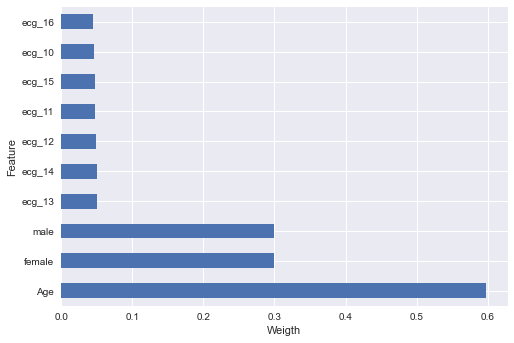

In [15]:
plt.style.use("seaborn")

pd.Series(abs(svmlinear_model.coef_[0]), index=X_train.columns).nlargest(10).plot(kind='barh');
plt.xlabel("Weigth")
plt.ylabel("Feature")

Text(0, 0.5, 'Feature')

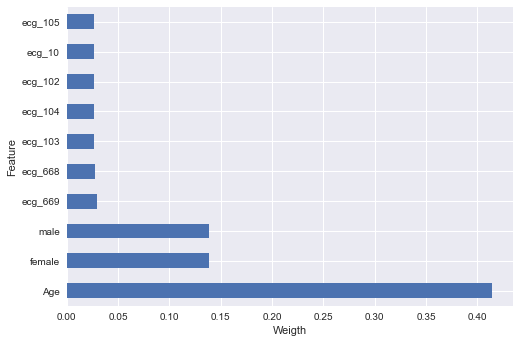

In [16]:
pd.Series(abs(svmlinear_model.coef_[10]), index=X_train.columns).nlargest(10).plot(kind='barh');
plt.xlabel("Weigth")
plt.ylabel("Feature")

Text(0, 0.5, 'Feature')

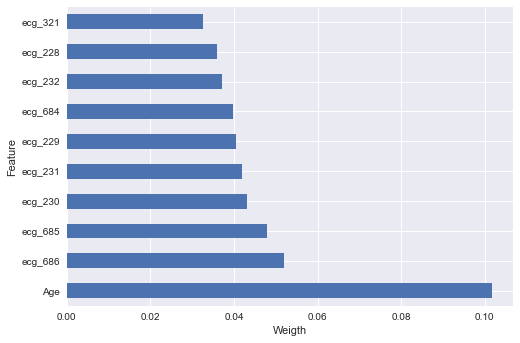

In [17]:
pd.Series(abs(svmlinear_model.coef_[100]), index=X_train.columns).nlargest(10).plot(kind='barh');
plt.xlabel("Weigth")
plt.ylabel("Feature")

Text(0, 0.5, 'Feature')

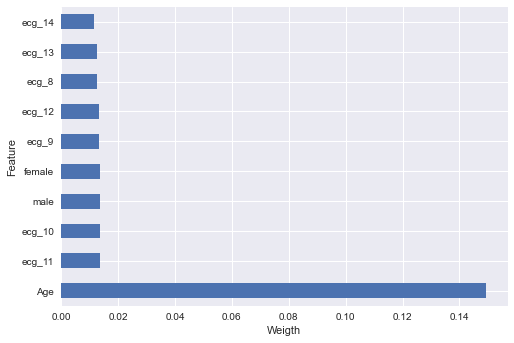

In [18]:
pd.Series(abs(svmlinear_model.coef_[1000]), index=X_train.columns).nlargest(10).plot(kind='barh');
plt.xlabel("Weigth")
plt.ylabel("Feature")

Even if age seems to have a great impact in all the classification pairs, and gender in some of them, the rest of the features are not consistent. Combining this information with the previous model performance that only used demographic features and other selected features, demographic information alone can not achieve this performance and thus the waveform has a substantial role in the performance of this model, achieving a way higher accuracy and performance in general. 

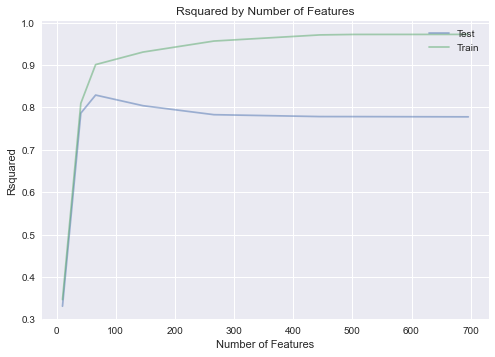

The best_cutoff for the model was 250.


In [19]:
# Cutoffs here pertains to the number of missing values allowed in the used columns.

cutoffs = [1000, 500, 250, 100, 25, 10, 5, 2]

r2_scores_test, r2_scores_train, svmlinear, X_train, X_test, y_train, y_test, best_cutoff = functions.find_optimal_model(X, y, cutoffs)
print("The best_cutoff for the model was {}.".format(best_cutoff))

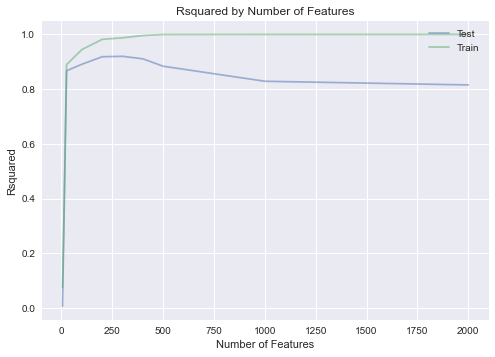

The best_cutoff for the model was 300.


In [20]:
# Cutoffs here pertains to the number of feature columns allowed by the model.

cutoffs = [2000, 1000, 500, 400, 300, 200, 100, 25, 10, 5]

r2_scores_test, r2_scores_train, svmlinear, X_train, X_test, y_train, y_test, best_cutoff = functions.find_optimal_model(X, y, cutoffs, cutoff_features=True)
print("The best_cutoff for the model was {}.".format(best_cutoff))

## 3.3 Conclusions

The raw ECG waveform used as features for the selected linear SVM classification model delivers better accuracy than demographic information of the subjects and point-based features extracted from the ECG waveform. Consequently, results show that the raw ECG waveform could be used as a biometric human identification measure for this specific database.
It remains the importance of a generalization of this method to a broader sample population to confirm this possibility. Additionally, the impact of aging in the ECG waveform, and thus, in the capacity of the model to detect these changes through time to identify correctly the subject, or the impact of disease affecting the ECG and the biometric identification. 